Etwas Styling ...

In [2]:
%%html
<style>
h1 { color: rgb(226, 0, 26); }
h2 { color: rgb(0, 80, 120); }
.output_png { display: table-cell;  text-align: center;  vertical-align: middle; }
</style>

# BigData - DBWeather
---
\
*Programmentwurf – Wintersemester 2022 – DHBW Mannheim*\
Daniel Czeschner, Kai Grübener, Frederik Wolter

## 0. Aufbau
<i>... in Anlehnung an CRISP-DM</i>
<center><img src="img/CRISP-DM.png" style="margin:0;"/></center>

## 1. Business Understanding

* __Perspektive__: Deutsche Bahn

* __Hypothese__: 

<center><i>Klimaanlagen sorgen für Störungen bei extremen Temperaturen, besonders bei ICE's</i></center>

* __Ziel__: 
  * Erhebung, Auswertung und Darstellung von Daten zu Fahrplan-Abweichungen
  * Erhebung von Wetterdaten für Analyse potentieller Korrelationen

## 2. Data Understanding

Verfügbare Datenquellen:
  1. Deutsche Bahn _Timetable_ API<br> 
    `apis.deutschebahn.com/db-api-marketplace/apis/timetables/`
  
  2. Deutsche Bahn _Reiseauskunft_ API<br>
    `reiseauskunft.bahn.de/bin/`
  
  3. _BrightSky_ API<br>
    `api.brightsky.dev/`

## 2.1 Data Understanding – DB Timetable

* API des Deutschen Bahn API-Marketplace

* `/station/{pattern}`
```xml
<station meta="518342" name="Mannheim Hbf" eva="8000244" p="..." ...="" />
```

* `/fchg/{evaNo}` \
  viele schlecht dokumentierte Daten über Fahrplan-Abweichungen u. a.
    * Zugtyp, Zugnummer, Baustellen, _Durchsagen?_
    * **geänderte** Gleise, Ankünfte, Abfahrten, Ausfälle

    <div class="alert alert-danger">
        <b>Achtung:</b> keine Plan-Daten (andere API) -> ungeignet für Verspätungsbestimmung
    </div>

## 2.2 Data Understanding – DB Reiseauskunft

* API der Deutschen Bahn - _"not so official"_

* `bhftafel.exe/dn?boardType={arr|dep}&input={evaNo}`
  
    <pre><code class="cm-s-ipython language-json" style="max-height: none;">    8000244 Mannheim Hbf
      17:23
      IC  2217
      <span class="cm-string cm-property">+ 36</span>
      17:24
      S      1
      <span class="cm-string cm-property">no</span>
      17:31
      ICE  611
      <span class="cm-string cm-property">cancel</span>
      17:33
      ICE  42
      <span class="cm-string cm-property">+ 5</span></code></pre>

## 2.3 Data Understanding – BrightSky

* API basierend auf Deutschen Wetterdienst

* `/weather?lat={Latitude}&lon={Longitude}&date={Date}`

    <pre><code class="cm-s-ipython language-json" style="max-height: none;">   <span class="cm-string">"weather"</span>: [{ 
                    <span class="cm-string cm-property">"timestamp"</span>: <span class="cm-string">"2022-11-03T00:00:00+01:00"</span>,
                    <span class="cm-string cm-property">"source_id"</span>: <span class="cm-number">184401</span>,
                    <span class="cm-string cm-property">"pressure_msl"</span>: <span class="cm-number">1021.7</span>,
                    <span class="cm-string cm-property">"sunshine"</span>: <span class="cm-number">0.0</span>,
                    <span class="cm-string cm-property">"temperature"</span>: <span class="cm-number">6.8</span>,     
                    <span class="cm-string cm-property">"condition"</span>: <span class="cm-string">"dry"</span>,
                    <span class="cm-string cm-property">"wind_speed"</span>: <span class="cm-number">4.3</span>,
                    <span class="cm-string cm-property">"cloud_cover"</span>: <span class="cm-number">100</span>,     
                    <span class="cm-string cm-property">"relative_humidity"</span>: <span class="cm-number">96</span>, <span class="cm-meta">...</span>
                  }, <span class="cm-meta">...</span> ],</code></pre>
    ```json
    "sources": [ ... ]
    ```

## 3. Data Preparation

__Abspeichern der Daten__

<center><i>Welche Daten, wie, in welchem Format speichern?</i></center>

## 3.1 Data Preparation – Zug

* Speichern als **einzelne** Ankunft/Abfahrt

* Hinzufügen von `eva` und `board_type`

* Parsen zu `JSON`:

    ```json
    {
        "timestamp": "2022-11-03T17:48:00+01:00",
        "eva": 8000244,
        "board_type": "arr",
        "con_line": "725",
        "con_type": "ICE",
        "delay": 26
    }
    ```
    
<div class="alert alert-block alert-info">
    <b>Info:</b> <code>delay</code> "cancel" wird als <code>-1</code> dargestellt
</div>
    

## 3.2 Data Preparation – Wetter

* Speichern als **stündliche** Datensätze

* Hinzufügen von `lon` und `lat`
    <pre><code class="cm-s-ipython language-json" style="max-height: none;">    { 
        <span class="cm-string cm-property">"timestamp"</span>: <span class="cm-string">"2022-11-25T14:00:00+01:00"</span>,
        <span class="cm-string cm-property">"lat"</span>: <span class="cm-number">49.5</span>,        
        <span class="cm-string cm-property">"lon"</span>: <span class="cm-number">8.48</span>,
        <span class="cm-string cm-property">"cloud_cover"</span>: <span class="cm-number">88</span>,   
        <span class="cm-string cm-property">"condition"</span>: <span class="cm-string">"dry"</span>,
        <span class="cm-string cm-property">"pressure_msl"</span>: <span class="cm-number">1018.8</span>,
        <span class="cm-string cm-property">"relative_humidity"</span>: <span class="cm-number">83</span>,
        <span class="cm-string cm-property">"sunshine"</span>: <span class="cm-number">32</span>,
        <span class="cm-string cm-property">"temperature"</span>: <span class="cm-number">9.2</span>,
        <span class="cm-string cm-property">"wind_speed"</span>: <span class="cm-number">10.1</span>, 
        <span class="cm-meta">...</span> 
      }</code></pre>

## 4. Modeling

Die Pipeline ist wie folgt aufgebaut:
<br>
<br>
<center><img src="img/DataPipeline.png" /></center>

## 4.1 Modeling – Datenbank
* Als Datenbank wurde eine **MongoDB** auf einem Debian-Server eingerichtet
* für dieses Projekt angelegt
  * _Datenbank_: `DBWeather`
  * _Collections_: `data_train`, `data_weather`

## 4.2 Modeling – Python
**Vereinfachtes Laden der Wetterdaten:**
<pre><code class="cm-s-ipython language-python" style="max-height: none;"><span class="cm-keyword">def</span> <span class="cm-def">_load_api_data</span>(<span class="cm-variable">lat</span>: <span class="cm-builtin">float</span>, <span class="cm-variable">lon</span>: <span class="cm-builtin">float</span>, <span class="cm-variable">current_time</span>: <span class="cm-variable">datetime</span>) <span class="cm-operator">-</span><span class="cm-operator">&gt;</span> <span class="cm-keyword">None</span>:
    <span class="cm-variable">url</span> <span class="cm-operator">=</span> <span class="cm-string">"https://api.brightsky.dev/weather"</span>
    <span class="cm-variable">params</span> <span class="cm-operator">=</span> { <span class="cm-string">"date"</span>: <span class="cm-variable">current_time</span>, <span class="cm-string">"lon"</span>: <span class="cm-variable">lon</span>, <span class="cm-string">"lat"</span>: <span class="cm-variable">lat</span>, <span class="cm-string">"tz"</span>: <span class="cm-string">"Europe/Berlin"</span> }
    <span class="cm-variable">r</span> <span class="cm-operator">=</span> <span class="cm-variable">requests</span>.<span class="cm-property">get</span>(<span class="cm-variable">url</span><span class="cm-operator">=</span><span class="cm-variable">url</span>, <span class="cm-variable">params</span><span class="cm-operator">=</span><span class="cm-variable">params</span>)

    <span class="cm-variable">answer</span> <span class="cm-operator">=</span> <span class="cm-variable">r</span>.<span class="cm-property">json</span>()
    <span class="cm-variable">weather</span> <span class="cm-operator">=</span> <span class="cm-variable">answer</span>[<span class="cm-string">"weather"</span>]

    <span class="cm-keyword">for</span> <span class="cm-variable">dataset</span> <span class="cm-keyword">in</span> <span class="cm-variable">weather</span>:
        <span class="cm-variable">dataset</span>[<span class="cm-string">"lat"</span>] <span class="cm-operator">=</span> <span class="cm-variable">lat</span>
        <span class="cm-variable">dataset</span>[<span class="cm-string">"lon"</span>] <span class="cm-operator">=</span> <span class="cm-variable">lon</span>
        <span class="cm-variable"><i><b>_save_to_db</b></i></span>(<span class="cm-variable">db</span><span class="cm-operator">=</span><span class="cm-variable">database</span>, <span class="cm-variable">dataset</span><span class="cm-operator">=</span><span class="cm-variable">dataset</span>)</code></pre>

## 4.2 Modeling – Python
**Speichern der Daten in MongoDB:**

* Wrapper-Skript für DB-Funktionalität von `pymongo`
  * Verbindung zur MongoDB & Collections auf- und abbauen
  * `upsert` Funktion:
  
```python
    def _save_to_db(db: Database, dataset: dict) -> None:
        keys = {
            "timestamp": dataset["timestamp"],
            "lat": dataset["lat"],
            "lon": dataset["lon"]
        }
        database.upsert(collection=db.data_weather, query=keys, update=dataset)
```

## 4.3 Modeling – Ausfürhung

* **Python-Skripte** durch Debian-Server via `cronjob` alle **30 Min.** ausgeführt
  
* Bei Ausführung wird ein **Log** erstellt:

    <pre style="font-size: 0.8em !important;"><code style="max-height: none;">  2022-11-03 19:00:01,408 INFO  weather: Start main_weather execution ...
    2022-11-03 19:00:01,708 INFO  weather: Result lat=50.05 lon=8.6 has 25 elements
    2022-11-03 19:00:01,824 INFO  weather: Result lat=49.5 lon=8.48 has 25 elements
    2022-11-03 19:00:01,844 INFO  weather: finished: 0 inserted, 2 updated, 48 unchanged
    2022-11-03 19:00:01,844 INFO  weather: ###########################################
    2022-11-03 19:00:01,915 INFO  train: Start main_train execution ...
    2022-11-03 19:00:01,917 INFO  train: Result eva=8000105 type=arr has 690 lines
    2022-11-03 19:00:02,493 INFO  train: Result eva=8000105 type=dep has 672 lines
    2022-11-03 19:00:02,938 INFO  train: Result eva=8000244 type=arr has 291 lines
    2022-11-03 19:00:03,233 INFO  train: Result eva=8000244 type=dep has 264 lines
    2022-11-03 19:00:03,301 INFO  train: finished: 295 inserted, 119 updated, 225 unchanged
    2022-11-03 19:00:03,301 INFO  train: ###########################################</code></pre>

## 4.4 Modeling – Auswertung

* __Visualisieren der Daten__: dieses `Jupyter Notebook`
* __Präsentation__: Jupyter Erweiterung [`Rise`](https://rise.readthedocs.io/en/stable/)

## 5. Evaluation
Benötigte Packages:

In [3]:
from pandas import DataFrame
from database import Database

Verbindung zur MongoDB durch Wrapper-Package `Database`:

In [4]:
database = Database()
data_train = database.mongo_data_train
data_weather = database.mongo_data_weather

In [5]:
# plot config
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["figure.figsize"] = [10.00, 4.00]

## 5.1 Evaluation – Wetter Einführung

In [6]:
print(f"{data_weather.count_documents({}):,} Datensätze")

2,738 Datensätze


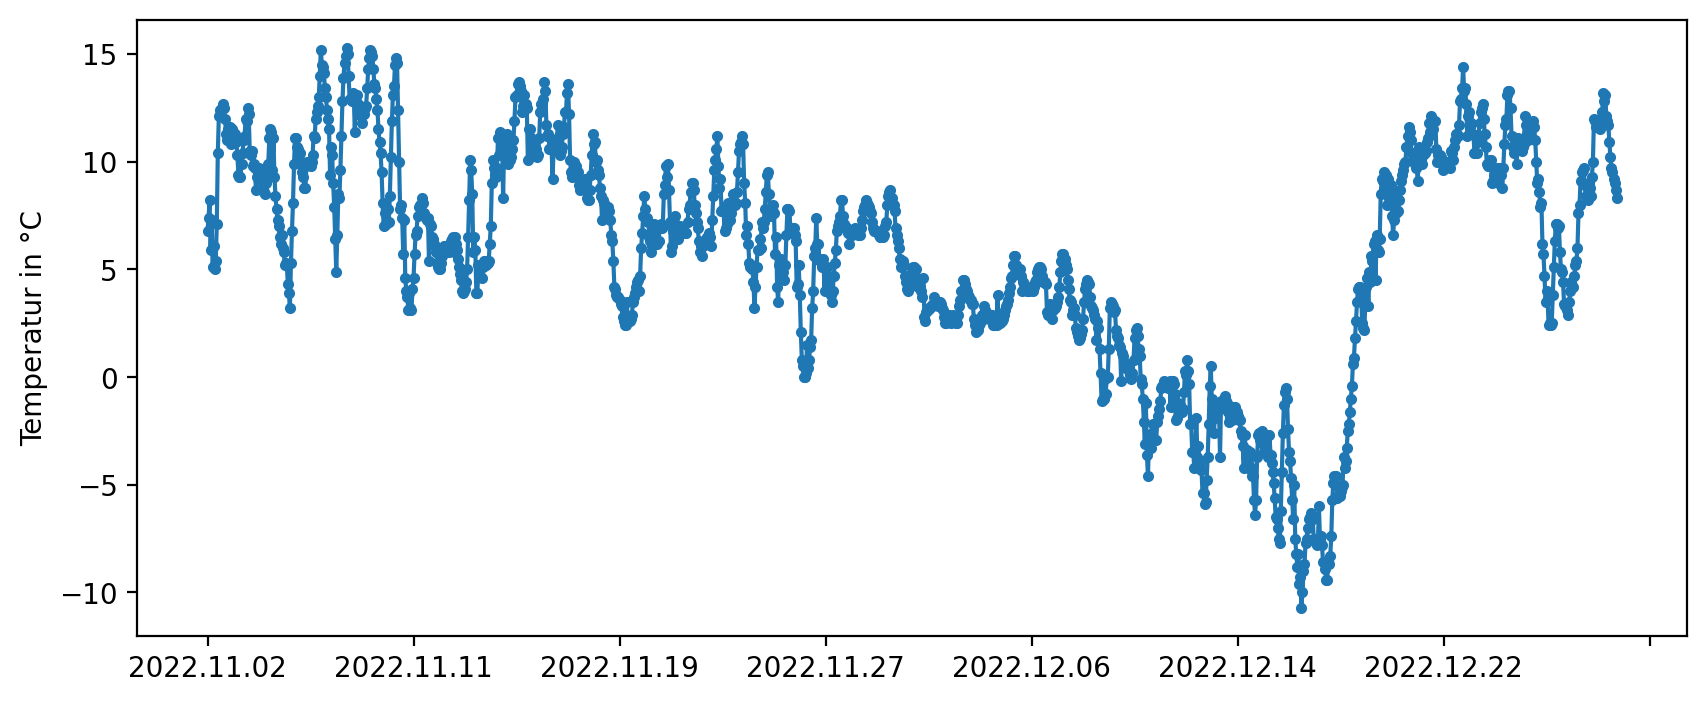

In [7]:
result = data_weather.aggregate([{"$match": {"$and": [{"lat": {"$eq": 49.5} }, {"lat": {"$eq": 49.5}}]}}, {"$sort": {"timestamp": 1}},{"$addFields": {"time": { "$dateToString": { "format": "%Y.%m.%d", "date": {"$toDate": "$timestamp"}}}}}])
p1 = DataFrame(result).plot(x="time", y="temperature", kind="line", xlabel="", ylabel="Temperatur in °C", style=".-", legend=None)

## 5.2 Evaluation – Züge Einführung

In [8]:
print(f"{data_train.count_documents({}):,} Datensätze")

572,664 Datensätze


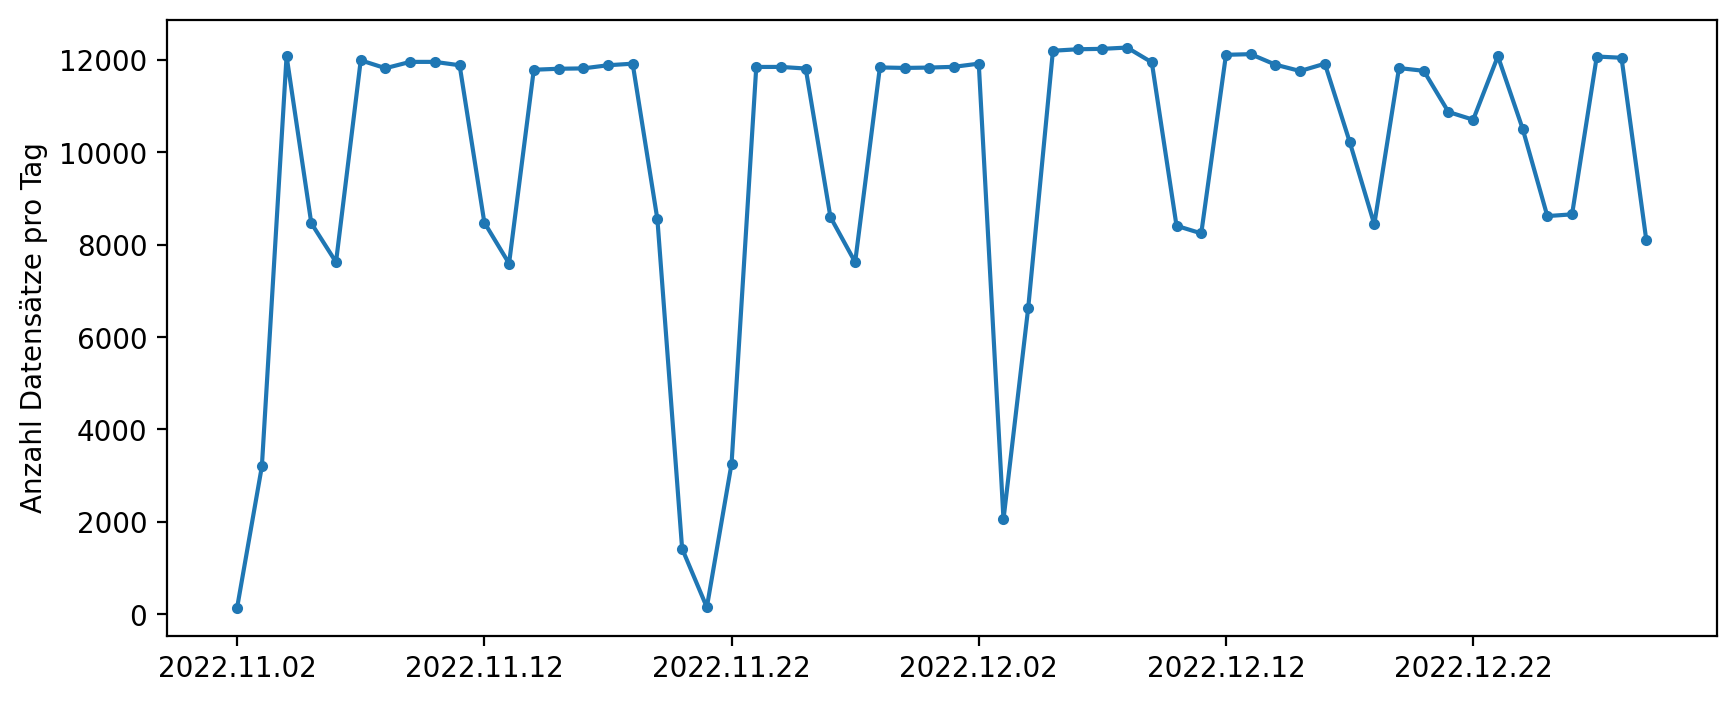

In [9]:
result = data_train.aggregate([{"$group": {"_id": {"$dateToString": {"format": "%Y.%m.%d", "date": {"$toDate": "$timestamp"}}}, "count": {"$sum": 1}}}, {"$sort": {"_id": 1}}])
p2 = DataFrame(result).plot(x="_id", y="count", kind="line", xlabel="", ylabel="Anzahl Datensätze pro Tag", style=".-", legend=None)

## 5.3 Evaluation – Zug-Arten

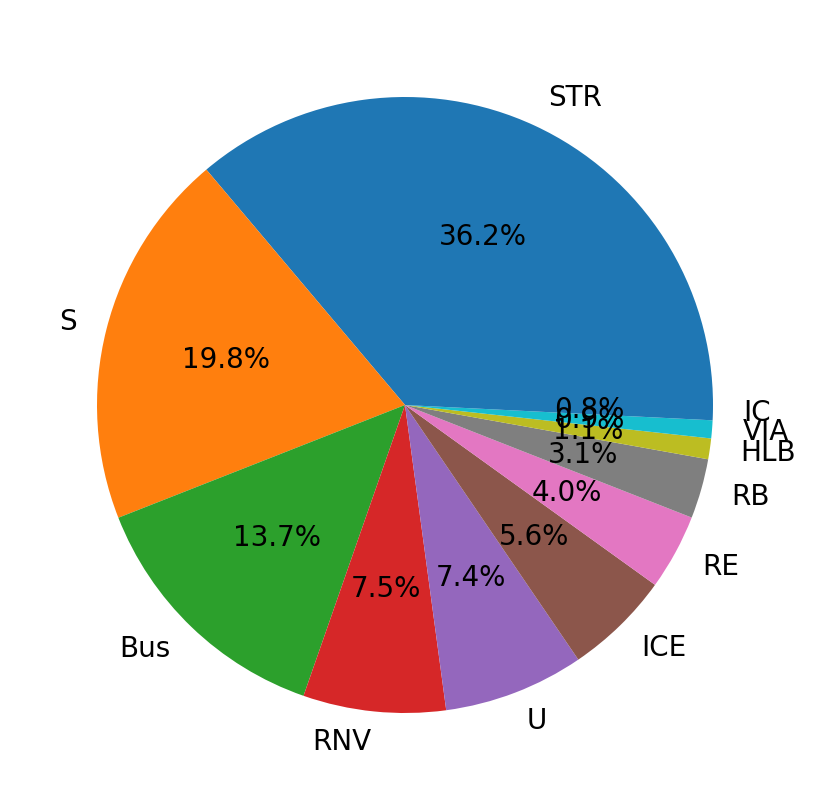

In [10]:
result = data_train.aggregate([{"$group": {"_id": "$con_type", "count": {"$sum": 1}}}, {"$sort": {"count": -1}}, {"$limit": 11}])
df = DataFrame(result)
p3 = df.plot(x="_id", y="count", kind="pie", labels=df["_id"], legend=False, figsize=(5,5), autopct="%1.1f%%", ylabel="")

## 5.4 Evaluation – Delay

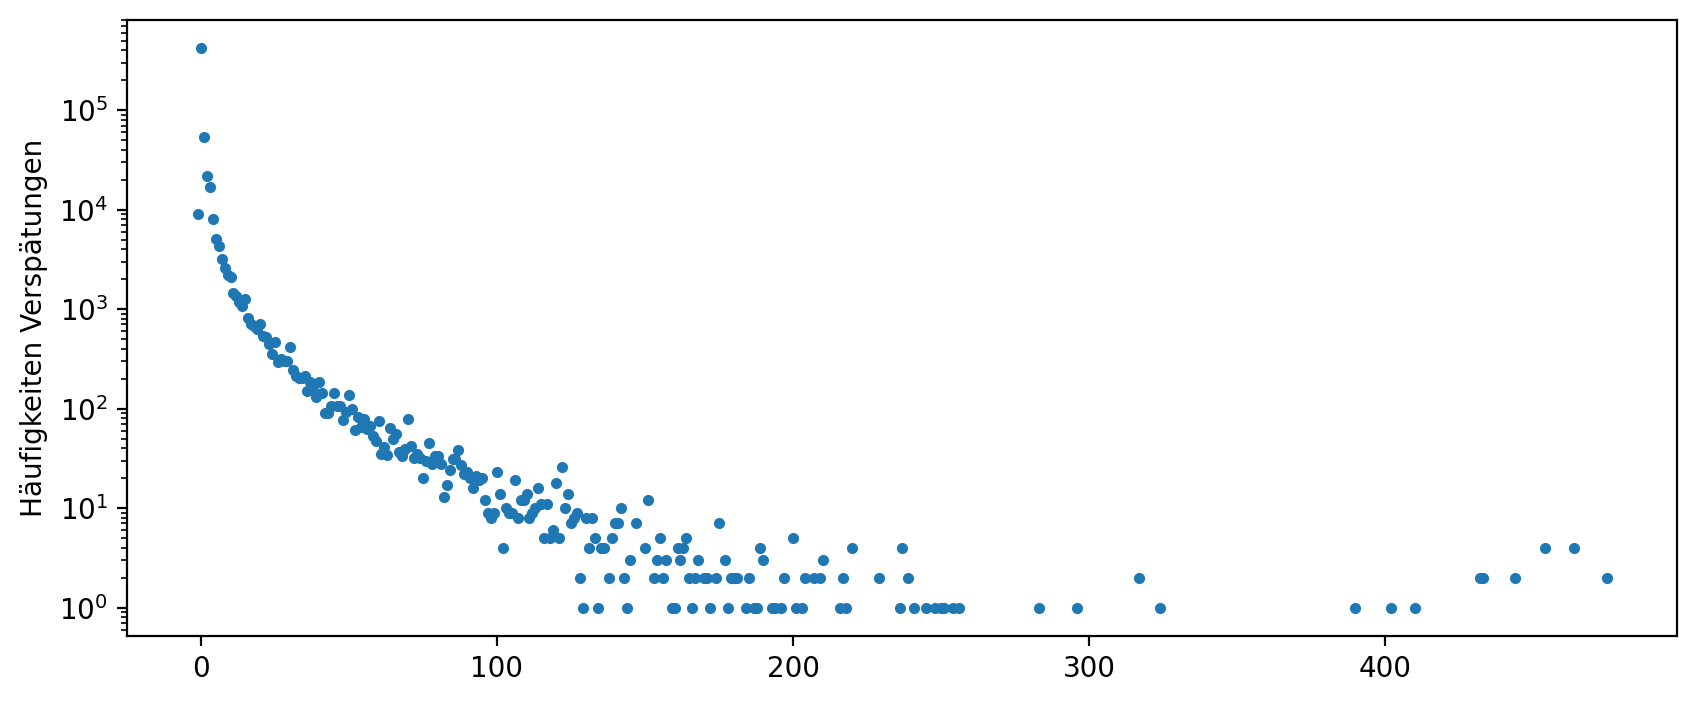

In [11]:
result = data_train.aggregate([{"$group": {"_id": "$delay", "count": {"$sum": 1}}}, {"$sort": {"count": 1}}])
p4 = DataFrame(result).plot(x="_id", y="count", kind="line", xlabel="", ylabel="Häufigkeiten Verspätungen", style=".", logy=True, legend=None)

## 5.5 Evaluation – Delay

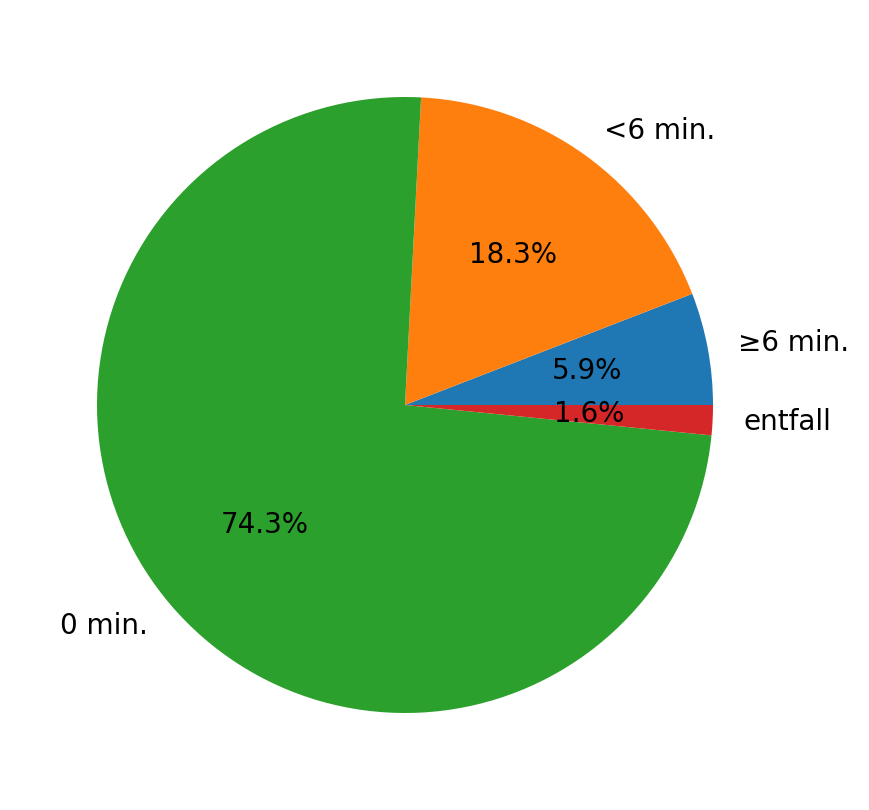

In [22]:
result = data_train.aggregate([{"$addFields": {"range": {"$switch": {"branches": [{"case": {"$eq": ["$delay", -1]}, "then": "entfall"}, {"case": {"$eq": ["$delay", 0]}, "then": "0 min."}, {"case": {"$lte": ["$delay", 5]}, "then": "<6 min."}], "default": "≥6 min."}}}}, {"$group": {"_id": "$range", "count": {"$sum": 1}}}])
df = DataFrame(result)
p5 = df.plot(x="_id", y="count", kind="pie", ylabel="", labels=df["_id"], legend=False, figsize=(5,5), autopct="%1.1f%%")

## 5.6 Evaluation – Delay ICE

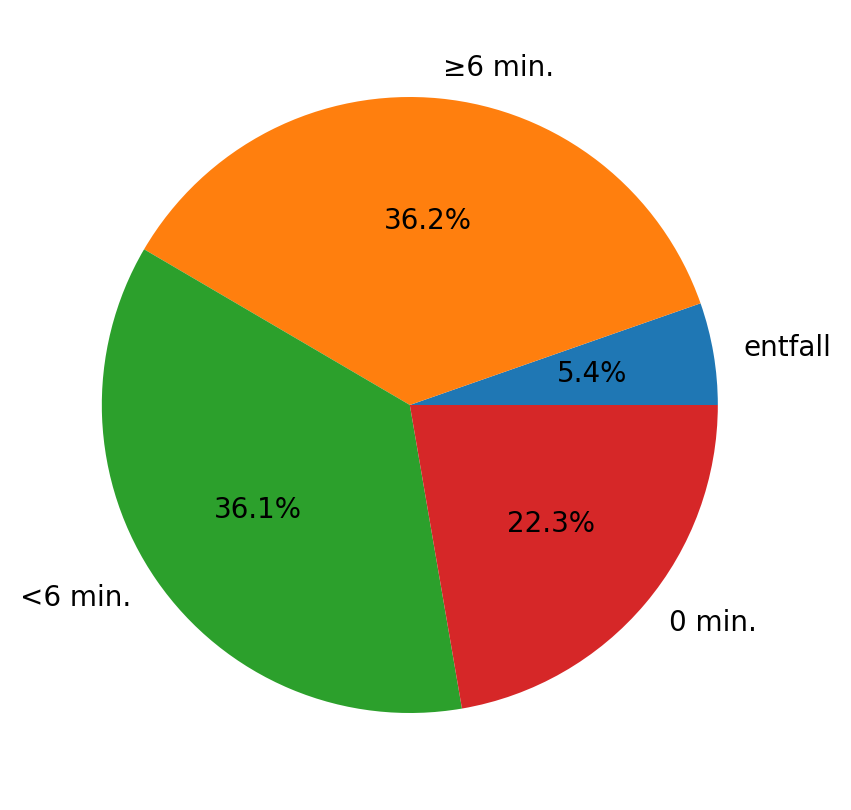

In [23]:
result = data_train.aggregate([{"$match": {"con_type": "ICE"}}, {"$addFields": {"range": {"$switch": {"branches": [{"case": { "$eq": ["$delay", -1]}, "then": "entfall"}, {"case": {"$eq": ["$delay",  0]}, "then": "0 min."}, {"case": {"$lte": ["$delay", 5]}, "then": "<6 min."}], "default": "≥6 min."}}}}, {"$group": {"_id": "$range", "count": {"$sum": 1}}}])
df = DataFrame(result)
p6 = df.plot(x="_id", y="count", kind="pie", ylabel="", labels=df["_id"], legend=False, figsize=(5,5), autopct="%1.1f%%")

## 5.7 Evaluation – Walk of Shame

In [14]:
DataFrame(data_train.find(sort=[("delay", -1)], filter={"board_type": "arr"}).limit(3))

,_id,board_type,con_line,con_type,eva,timestamp,delay
0,63647221e60c50489303e036,arr,11,STR,8000105,2022-11-04T03:36:00+01:00,475
1,63648031e60c50489303e355,arr,11,STR,8000105,2022-11-04T04:40:00+01:00,464
2,63648031e60c50489303e34f,arr,11,STR,8000105,2022-11-04T04:39:00+01:00,464


... ohne Straßenbahnen ...

In [15]:
DataFrame(data_train.find(sort=[("delay", -1)], filter={"board_type": "arr","con_type": {"$ne": "STR"}}).limit(3))

,_id,board_type,con_line,con_type,eva,timestamp,delay
0,63ac36caa8ff1821bb17d806,arr,24736,STN,8000105,2022-12-28T14:10:00+01:00,402
1,638d65b9a8ff1821bb0a173c,arr,2943,NJ,8000105,2022-12-05T02:30:00+01:00,390
2,63ac21b2a8ff1821bb17ccb5,arr,24730,STN,8000105,2022-12-28T12:40:00+01:00,324


## 5.8 Evaluation – Züge + Temperatur

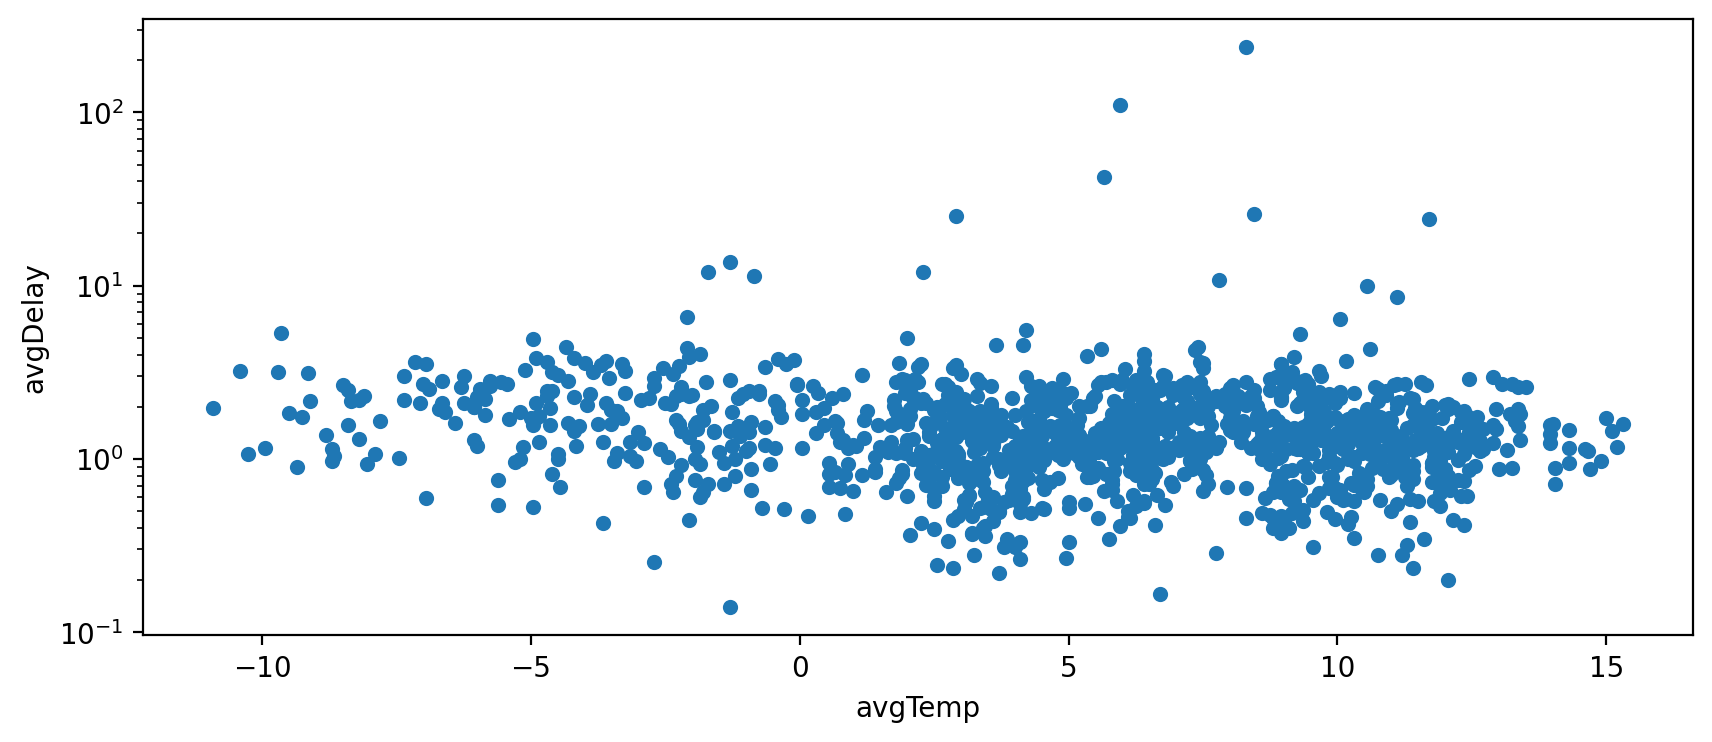

In [16]:
result = data_train.aggregate([{"$match": {"$and": [{"delay": {"$ne": -1}}]}},
    {"$group": {"_id": { "$dateToString": {"format": "%Y.%m.%d.%H", "date": {"$toDate": "$timestamp"}}}, "avgDelay": {"$avg": "$delay"}}},
    {"$lookup": {"from": "data_weather", "let": {"train_time": "$_id"}, "pipeline": [{"$group": {"_id": { "$dateToString": {"format": "%Y.%m.%d.%H", "date": {"$toDate": "$timestamp"}}}, "avgTemp": {"$avg": "$temperature"}}}, {"$match": {"$expr": {"$eq": ["$$train_time", "$_id"]}}}], "as": "weather"}}, {"$unwind": "$weather"},{"$addFields": {"avgTemp": "$weather.avgTemp"}}])
p7 = DataFrame(result).plot(x="avgTemp", y="avgDelay", kind="scatter", logy=True)

## 5.9 Evaluation – Züge + Temperatur (ICE)

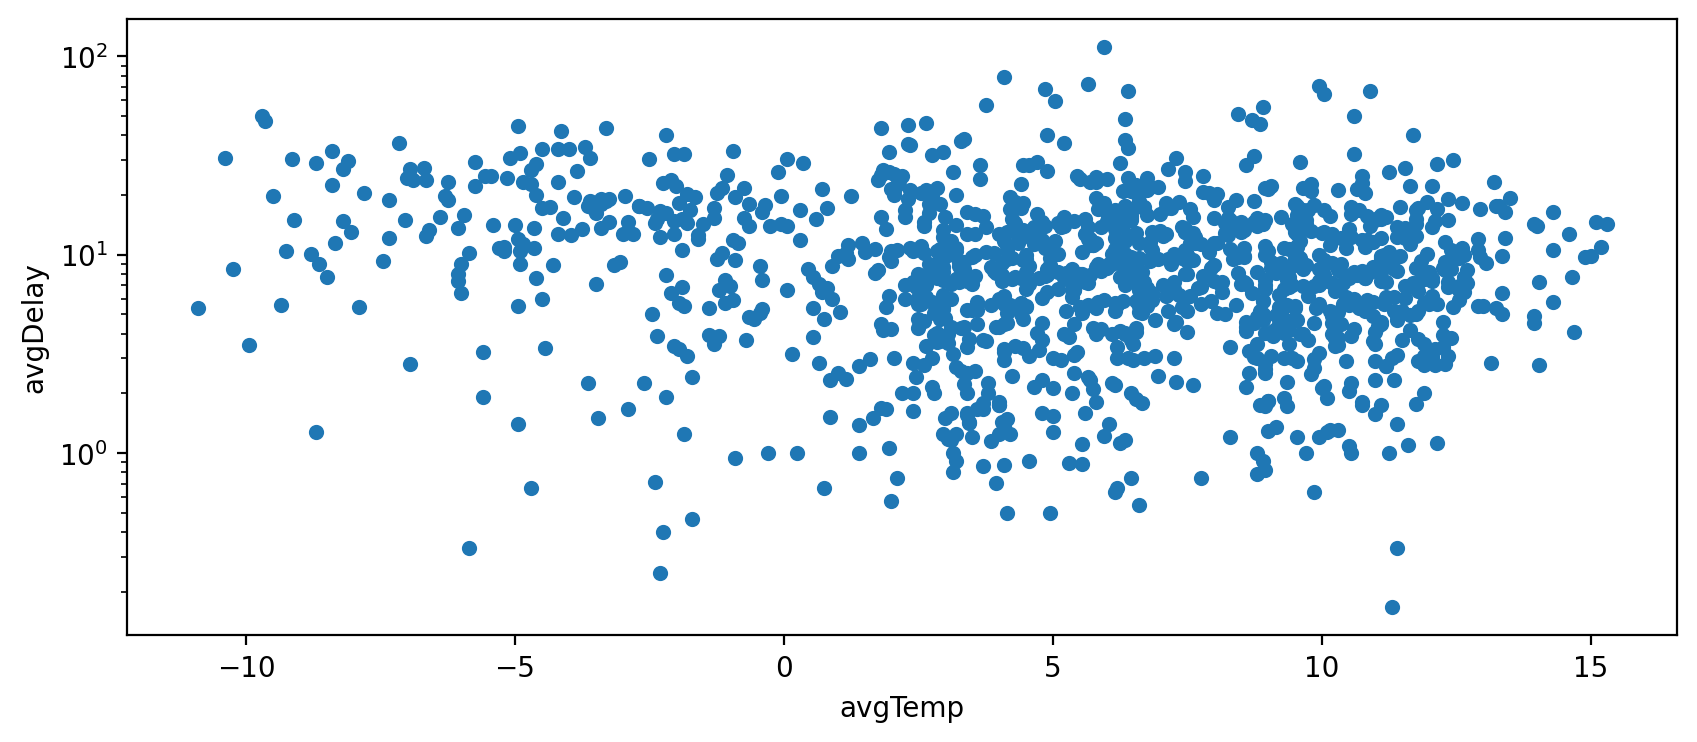

In [17]:
result = data_train.aggregate([{"$match": {"$and": [{"delay": {"$ne": -1}}, {"con_type": {"$eq": "ICE"}}]}},
    {"$group": {"_id": { "$dateToString": {"format": "%Y.%m.%d.%H", "date": {"$toDate": "$timestamp"}}}, "avgDelay": {"$avg": "$delay"}}},
    {"$lookup": {"from": "data_weather", "let": {"train_time": "$_id"}, "pipeline": [{"$group": {"_id": { "$dateToString": {"format": "%Y.%m.%d.%H", "date": {"$toDate": "$timestamp"}}}, "avgTemp": {"$avg": "$temperature"}}}, {"$match": {"$expr": {"$eq": ["$$train_time", "$_id"]}}}], "as": "weather"}}, {"$unwind": "$weather"}, {"$addFields": {"avgTemp": "$weather.avgTemp"}}])
p8 = DataFrame(result).plot(x="avgTemp", y="avgDelay", kind="scatter", logy=True)

## 6. Deployment  – Fazit

* **Sonstige Probleme/Herausforderungen**: 
  * Server ist im Betrieb eingefroren aus unbekannter Ursache
  * erst nach zwei Tagen festgestellt, da Monitoring-Software nicht ausgelöst
  
  
* **Eingangshypothese**: 
  * noch nicht genug Daten für zuverlässige Aussagen

# ENDE ====================

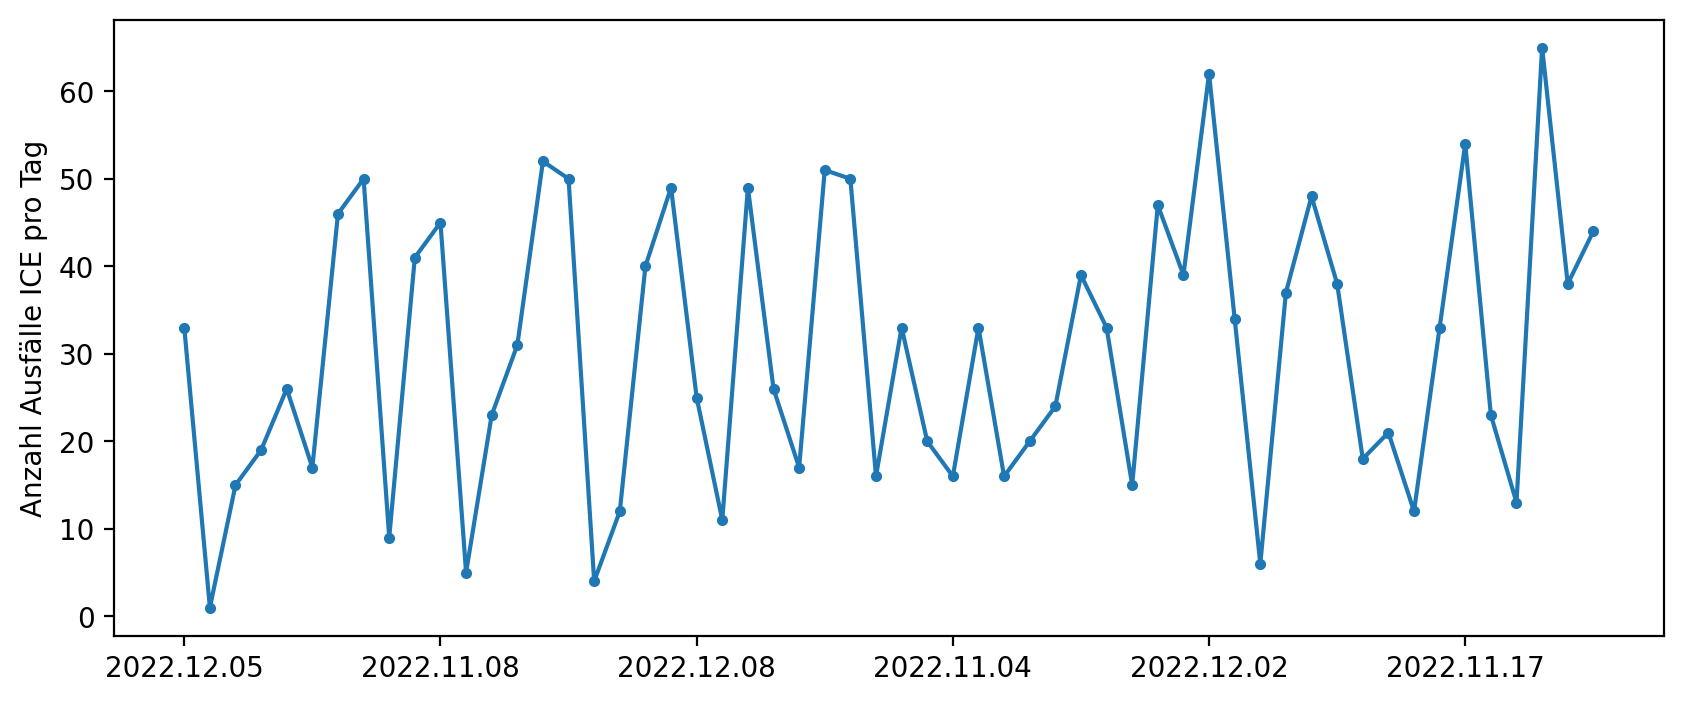

In [18]:
result = data_train.aggregate([{"$match": {"$and": [{"delay": {"$eq": -1}}, {"con_type": {"$eq": "ICE"}}]}}, {"$group": {"_id": { "$dateToString": {"format": "%Y.%m.%d", "date": {"$toDate": "$timestamp"}}}, "count": {"$sum": 1}}}])
p9 = DataFrame(result).plot(x="_id", y="count", kind="line", xlabel="", ylabel="Anzahl Ausfälle ICE pro Tag", style=".-", legend=None)

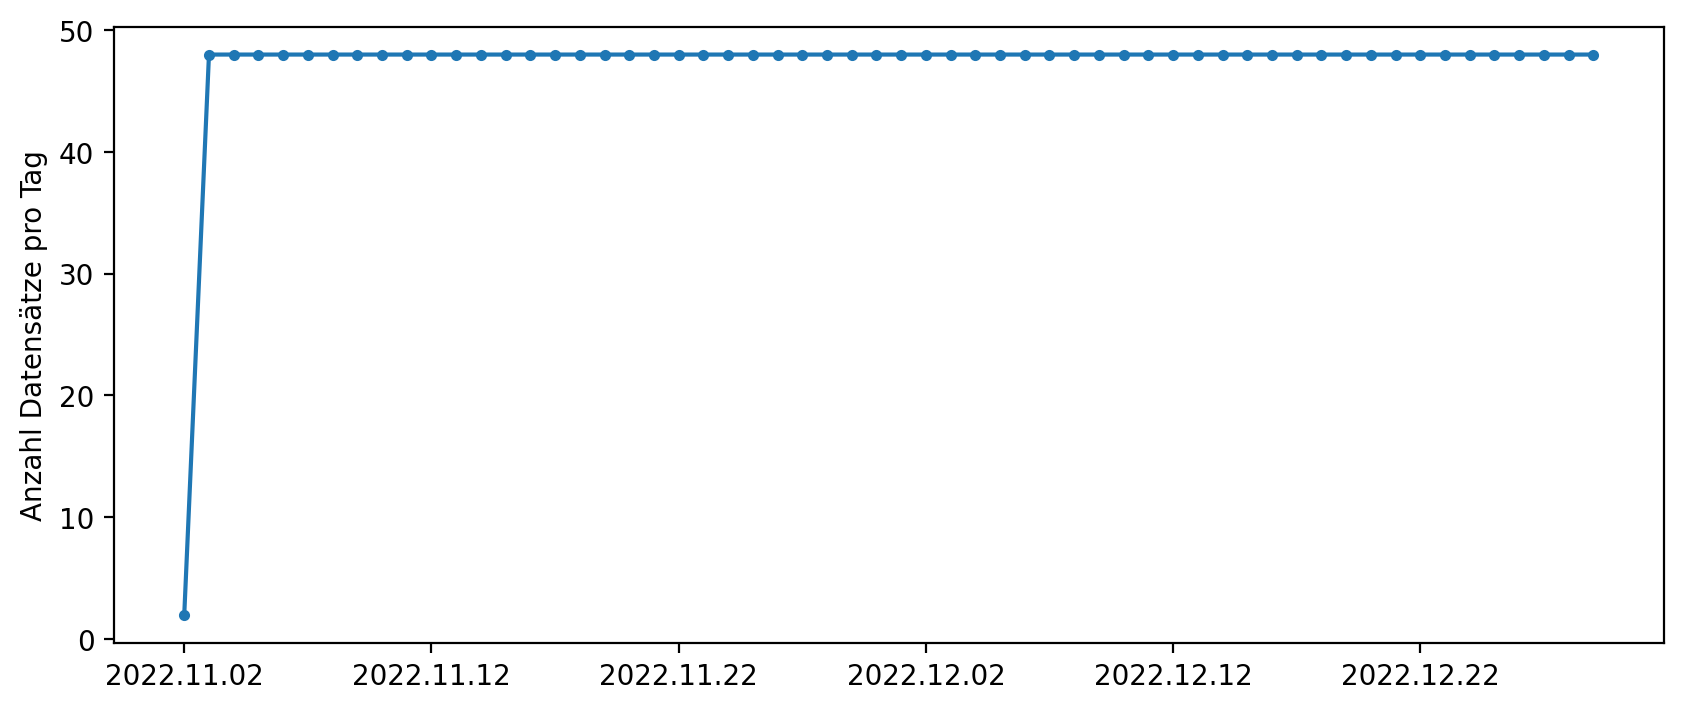

In [19]:
result = data_weather.aggregate([{"$group": {"_id": {"$dateToString": {"format": "%Y.%m.%d", "date": {"$toDate": "$timestamp"}}}, "count": {"$sum": 1}}}, {"$sort": {"_id": 1}}])
p10 = DataFrame(result).plot(x="_id", y="count", kind="line", xlabel="", ylabel="Anzahl Datensätze pro Tag", style=".-", legend=None)

Datenbank trennen:

In [20]:
database.close()